# Method 8 - Rest Ideas After 15

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Use Raw Weight

valid_data['adj_target'] = valid_data['target']

## Calculate Rest Ideas

In [3]:
# Extract Rest Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] > 15].copy()

# Weight the best ideas

best_ideas['target'] = best_ideas['target'] / best_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / best_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

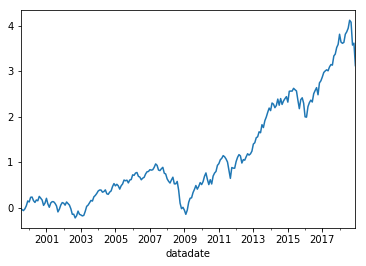

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.146150
2000-12-31   -0.041218
2001-12-31    0.010445
2002-12-31   -0.231527
2003-12-31    0.535187
2004-12-31    0.166420
2005-12-31    0.057809
2006-12-31    0.110260
2007-12-31   -0.031195
2008-12-31   -0.420960
2009-12-31    0.539991
2010-12-31    0.243978
2011-12-31   -0.032593
2012-12-31    0.200875
2013-12-31    0.422973
2014-12-31    0.078796
2015-12-31   -0.042102
2016-12-31    0.149494
2017-12-31    0.211390
2018-12-31   -0.101760
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     2048.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          6.40e-178
Time:                        06:53:32   Log-Likelihood:                 774.18
No. Observations:                 234   AIC:                            -1538.
Df Residuals:                     229   BIC:                            -1521.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      4.430      0.000       0.001       0.004
mktrf          1.0352      0.017     62.047      0.000       1.002       1.068
me             0.3227      0.019     16.630      0.000       0.285       0.361
ia             0.1012      0.029      3.431      0.001       0.043       0.159
roe           -0.2141      0.025     -8.480      0.000      -0.264      -0.164
==============================================================================
Omnibus:                       29.569   Durbin-Watson:                   1.854
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              119.375
Skew:                           0.363   Prob(JB):                     1.20e-26
Kurtosis:                       6.423   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     1725.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.21e-169
Time:                        06:53:32   Log-Likelihood:                 774.18
No. Observations:                 234   AIC:                            -1538.
Df Residuals:                     229   BIC:                            -1521.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      3.468      0.001       0.001       0.004
mktrf          1.0352      0.021     50.206      0.000       0.995       1.076
me             0.3227      0.043      7.459      0.000       0.238       0.408
ia             0.1012      0.052      1.947      0.052      -0.001       0.203
roe           -0.2141      0.044     -4.891      0.000      -0.300      -0.128
==============================================================================
Omnibus:                       29.569   Durbin-Watson:                   1.854
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              119.375
Skew:                           0.363   Prob(JB):                     1.20e-26
Kurtosis:                       6.423   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     2220.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          7.89e-182
Time:                        06:53:32   Log-Likelihood:                 774.18
No. Observations:                 234   AIC:                            -1538.
Df Residuals:                     229   BIC:                            -1521.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      3.270      0.001       0.001       0.004
mktrf          1.0352      0.021     49.176      0.000       0.994       1.076
me             0.3227      0.044      7.316      0.000       0.236       0.409
ia             0.1012      0.048      2.109      0.035       0.007       0.195
roe           -0.2141      0.047     -4.567      0.000      -0.306      -0.122
==============================================================================
Omnibus:                       29.569   Durbin-Watson:                   1.854
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              119.375
Skew:                           0.363   Prob(JB):                     1.20e-26
Kurtosis:                       6.423   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     1300.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.33e-165
Time:                        06:53:32   Log-Likelihood:                 748.47
No. Observations:                 234   AIC:                            -1485.
Df Residuals:                     228   BIC:                            -1464.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      2.929      0.004       0.001       0.003
mktrf          1.0766      0.019     57.573      0.000       1.040       1.113
smb            0.3797      0.025     15.390      0.000       0.331       0.428
hml            0.0720      0.029      2.476      0.014       0.015       0.129
rmw           -0.1095      0.033     -3.330      0.001      -0.174      -0.045
cma            0.0289      0.042      0.691      0.490      -0.053       0.111
==============================================================================
Omnibus:                       69.564   Durbin-Watson:                   1.794
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              342.775
Skew:                           1.073   Prob(JB):                     3.69e-75
Kurtosis:                       8.527   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     1103.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.55e-157
Time:                        06:53:32   Log-Likelihood:                 748.47
No. Observations:                 234   AIC:                            -1485.
Df Residuals:                     228   BIC:                            -1464.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      2.529      0.011       0.000       0.004
mktrf          1.0766      0.018     61.137      0.000       1.042       1.111
smb            0.3797      0.040      9.492      0.000       0.301       0.458
hml            0.0720      0.058      1.248      0.212      -0.041       0.185
rmw           -0.1095      0.048     -2.286      0.022      -0.203      -0.016
cma            0.0289      0.062      0.466      0.641      -0.093       0.150
==============================================================================
Omnibus:                       69.564   Durbin-Watson:                   1.794
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              342.775
Skew:                           1.073   Prob(JB):                     3.69e-75
Kurtosis:                       8.527   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     1361.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.46e-167
Time:                        06:53:32   Log-Likelihood:                 748.47
No. Observations:                 234   AIC:                            -1485.
Df Residuals:                     228   BIC:                            -1464.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      2.289      0.022       0.000       0.004
mktrf          1.0766      0.017     62.280      0.000       1.043       1.110
smb            0.3797      0.037     10.265      0.000       0.307       0.452
hml            0.0720      0.055      1.311      0.190      -0.036       0.180
rmw           -0.1095      0.054     -2.038      0.042      -0.215      -0.004
cma            0.0289      0.059      0.490      0.624      -0.087       0.145
==============================================================================
Omnibus:                       69.564   Durbin-Watson:                   1.794
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              342.775
Skew:                           1.073   Prob(JB):                     3.69e-75
Kurtosis:                       8.527   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     1971.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          4.53e-176
Time:                        06:53:32   Log-Likelihood:                 769.83
No. Observations:                 234   AIC:                            -1530.
Df Residuals:                     229   BIC:                            -1512.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      3.817      0.000       0.001       0.004
mktrf          1.0450      0.016     66.779      0.000       1.014       1.076
smb            0.4335      0.020     22.192      0.000       0.395       0.472
hml            0.0981      0.019      5.057      0.000       0.060       0.136
umd           -0.1172      0.013     -9.203      0.000      -0.142      -0.092
==============================================================================
Omnibus:                       18.927   Durbin-Watson:                   1.807
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.197
Skew:                           0.214   Prob(JB):                     6.27e-13
Kurtosis:                       5.362   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     1671.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          4.04e-168
Time:                        06:53:32   Log-Likelihood:                 769.83
No. Observations:                 234   AIC:                            -1530.
Df Residuals:                     229   BIC:                            -1512.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      2.893      0.004       0.001       0.004
mktrf          1.0450      0.018     59.257      0.000       1.010       1.080
smb            0.4335      0.028     15.760      0.000       0.380       0.487
hml            0.0981      0.048      2.025      0.043       0.003       0.193
umd           -0.1172      0.023     -5.181      0.000      -0.161      -0.073
==============================================================================
Omnibus:                       18.927   Durbin-Watson:                   1.807
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.197
Skew:                           0.214   Prob(JB):                     6.27e-13
Kurtosis:                       5.362   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     1957.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          9.65e-176
Time:                        06:53:32   Log-Likelihood:                 769.83
No. Observations:                 234   AIC:                            -1530.
Df Residuals:                     229   BIC:                            -1512.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      2.629      0.009       0.001       0.004
mktrf          1.0450      0.015     70.209      0.000       1.016       1.074
smb            0.4335      0.028     15.384      0.000       0.378       0.489
hml            0.0981      0.052      1.889      0.059      -0.004       0.200
umd           -0.1172      0.019     -6.097      0.000      -0.155      -0.080
==============================================================================
Omnibus:                       18.927   Durbin-Watson:                   1.807
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.197
Skew:                           0.214   Prob(JB):                     6.27e-13
Kurtosis:                       5.362   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     894.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.34e-85
Time:                        06:53:32   Log-Likelihood:                 374.77
No. Observations:                 120   AIC:                            -739.5
Df Residuals:                     115   BIC:                            -725.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0042      0.001      4.005      0.000       0.002       0.006
mktrf          1.0325      0.028     36.816      0.000       0.977       1.088
me             0.2800      0.028     10.110      0.000       0.225       0.335
ia             0.1422      0.043      3.278      0.001       0.056       0.228
roe           -0.2425      0.038     -6.317      0.000      -0.319      -0.166
==============================================================================
Omnibus:                        8.238   Durbin-Watson:                   1.883
Prob(Omnibus):                  0.016   Jarque-Bera (JB):               13.541
Skew:                           0.250   Prob(JB):                      0.00115
Kurtosis:                       4.568   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     1341.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.86e-95
Time:                        06:53:33   Log-Likelihood:                 374.77
No. Observations:                 120   AIC:                            -739.5
Df Residuals:                     115   BIC:                            -725.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0042      0.001      3.044      0.002       0.001       0.007
mktrf          1.0325      0.028     37.114      0.000       0.978       1.087
me             0.2800      0.045      6.250      0.000       0.192       0.368
ia             0.1422      0.060      2.363      0.018       0.024       0.260
roe           -0.2425      0.052     -4.646      0.000      -0.345      -0.140
==============================================================================
Omnibus:                        8.238   Durbin-Watson:                   1.883
Prob(Omnibus):                  0.016   Jarque-Bera (JB):               13.541
Skew:                           0.250   Prob(JB):                      0.00115
Kurtosis:                       4.568   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     2395.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.05e-109
Time:                        06:53:33   Log-Likelihood:                 374.77
No. Observations:                 120   AIC:                            -739.5
Df Residuals:                     115   BIC:                            -725.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0042      0.002      2.768      0.006       0.001       0.007
mktrf          1.0325      0.027     37.794      0.000       0.979       1.086
me             0.2800      0.047      5.923      0.000       0.187       0.373
ia             0.1422      0.050      2.836      0.005       0.044       0.240
roe           -0.2425      0.055     -4.437      0.000      -0.350      -0.135
==============================================================================
Omnibus:                        8.238   Durbin-Watson:                   1.883
Prob(Omnibus):                  0.016   Jarque-Bera (JB):               13.541
Skew:                           0.250   Prob(JB):                      0.00115
Kurtosis:                       4.568   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     547.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.11e-78
Time:                        06:53:33   Log-Likelihood:                 359.84
No. Observations:                 120   AIC:                            -707.7
Df Residuals:                     114   BIC:                            -691.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.001      3.202      0.002       0.001       0.006
mktrf          1.1285      0.034     33.547      0.000       1.062       1.195
smb            0.3640      0.038      9.553      0.000       0.288       0.439
hml            0.0500      0.047      1.071      0.286      -0.042       0.142
rmw           -0.0770      0.055     -1.399      0.165      -0.186       0.032
cma            0.0876      0.060      1.453      0.149      -0.032       0.207
==============================================================================
Omnibus:                       28.188   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.765
Skew:                           0.878   Prob(JB):                     7.09e-16
Kurtosis:                       6.296   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     699.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.04e-84
Time:                        06:53:33   Log-Likelihood:                 359.84
No. Observations:                 120   AIC:                            -707.7
Df Residuals:                     114   BIC:                            -691.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.001      2.739      0.006       0.001       0.007
mktrf          1.1285      0.030     37.306      0.000       1.069       1.188
smb            0.3640      0.054      6.774      0.000       0.259       0.469
hml            0.0500      0.090      0.556      0.578      -0.126       0.226
rmw           -0.0770      0.073     -1.062      0.288      -0.219       0.065
cma            0.0876      0.073      1.205      0.228      -0.055       0.230
==============================================================================
Omnibus:                       28.188   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.765
Skew:                           0.878   Prob(JB):                     7.09e-16
Kurtosis:                       6.296   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     1106.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.26e-95
Time:                        06:53:33   Log-Likelihood:                 359.84
No. Observations:                 120   AIC:                            -707.7
Df Residuals:                     114   BIC:                            -691.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.002      2.502      0.012       0.001       0.007
mktrf          1.1285      0.029     39.072      0.000       1.072       1.185
smb            0.3640      0.050      7.269      0.000       0.266       0.462
hml            0.0500      0.089      0.565      0.572      -0.123       0.223
rmw           -0.0770      0.080     -0.968      0.333      -0.233       0.079
cma            0.0876      0.069      1.279      0.201      -0.047       0.222
==============================================================================
Omnibus:                       28.188   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.765
Skew:                           0.878   Prob(JB):                     7.09e-16
Kurtosis:                       6.296   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     886.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.19e-85
Time:                        06:53:33   Log-Likelihood:                 374.26
No. Observations:                 120   AIC:                            -738.5
Df Residuals:                     115   BIC:                            -724.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0041      0.001      4.051      0.000       0.002       0.006
mktrf          1.0578      0.025     42.631      0.000       1.009       1.107
smb            0.4278      0.028     15.141      0.000       0.372       0.484
hml            0.1159      0.028      4.097      0.000       0.060       0.172
umd           -0.1239      0.017     -7.104      0.000      -0.158      -0.089
==============================================================================
Omnibus:                        5.650   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.059   Jarque-Bera (JB):                8.600
Skew:                           0.063   Prob(JB):                       0.0136
Kurtosis:                       4.305   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     1011.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.42e-88
Time:                        06:53:33   Log-Likelihood:                 374.26
No. Observations:                 120   AIC:                            -738.5
Df Residuals:                     115   BIC:                            -724.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0041      0.001      3.526      0.000       0.002       0.006
mktrf          1.0578      0.028     38.330      0.000       1.004       1.112
smb            0.4278      0.033     12.824      0.000       0.362       0.493
hml            0.1159      0.065      1.776      0.076      -0.012       0.244
umd           -0.1239      0.025     -4.865      0.000      -0.174      -0.074
==============================================================================
Omnibus:                        5.650   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.059   Jarque-Bera (JB):                8.600
Skew:                           0.063   Prob(JB):                       0.0136
Kurtosis:                       4.305   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     1290.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.67e-94
Time:                        06:53:33   Log-Likelihood:                 374.26
No. Observations:                 120   AIC:                            -738.5
Df Residuals:                     115   BIC:                            -724.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0041      0.001      3.238      0.001       0.002       0.007
mktrf          1.0578      0.023     46.876      0.000       1.014       1.102
smb            0.4278      0.035     12.060      0.000       0.358       0.497
hml            0.1159      0.069      1.673      0.094      -0.020       0.252
umd           -0.1239      0.021     -5.800      0.000      -0.166      -0.082
==============================================================================
Omnibus:                        5.650   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.059   Jarque-Bera (JB):                8.600
Skew:                           0.063   Prob(JB):                       0.0136
Kurtosis:                       4.305   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     2018.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          3.40e-101
Time:                        06:53:33   Log-Likelihood:                 437.47
No. Observations:                 114   AIC:                            -864.9
Df Residuals:                     109   BIC:                            -851.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.001      2.855      0.005       0.000       0.003
mktrf          1.0259      0.016     65.438      0.000       0.995       1.057
me             0.4262      0.024     17.609      0.000       0.378       0.474
ia            -0.0229      0.034     -0.682      0.496      -0.089       0.044
roe           -0.1935      0.030     -6.558      0.000      -0.252      -0.135
==============================================================================
Omnibus:                        6.540   Durbin-Watson:                   2.117
Prob(Omnibus):                  0.038   Jarque-Bera (JB):                6.318
Skew:                          -0.573   Prob(JB):                       0.0425
Kurtosis:                       3.130   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     2420.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.93e-105
Time:                        06:53:33   Log-Likelihood:                 437.47
No. Observations:                 114   AIC:                            -864.9
Df Residuals:                     109   BIC:                            -851.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.000      3.574      0.000       0.001       0.002
mktrf          1.0259      0.015     69.569      0.000       0.997       1.055
me             0.4262      0.022     19.573      0.000       0.384       0.469
ia            -0.0229      0.032     -0.718      0.473      -0.085       0.040
roe           -0.1935      0.024     -8.134      0.000      -0.240      -0.147
==============================================================================
Omnibus:                        6.540   Durbin-Watson:                   2.117
Prob(Omnibus):                  0.038   Jarque-Bera (JB):                6.318
Skew:                          -0.573   Prob(JB):                       0.0425
Kurtosis:                       3.130   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     3280.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.43e-112
Time:                        06:53:33   Log-Likelihood:                 437.47
No. Observations:                 114   AIC:                            -864.9
Df Residuals:                     109   BIC:                            -851.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.000      3.855      0.000       0.001       0.002
mktrf          1.0259      0.014     72.041      0.000       0.998       1.054
me             0.4262      0.021     20.337      0.000       0.385       0.467
ia            -0.0229      0.035     -0.654      0.513      -0.092       0.046
roe           -0.1935      0.022     -8.871      0.000      -0.236      -0.151
==============================================================================
Omnibus:                        6.540   Durbin-Watson:                   2.117
Prob(Omnibus):                  0.038   Jarque-Bera (JB):                6.318
Skew:                          -0.573   Prob(JB):                       0.0425
Kurtosis:                       3.130   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     1597.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.79e-99
Time:                        06:53:33   Log-Likelihood:                 437.37
No. Observations:                 114   AIC:                            -862.7
Df Residuals:                     108   BIC:                            -846.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.926      0.356      -0.001       0.002
mktrf          1.0386      0.015     69.082      0.000       1.009       1.068
smb            0.4052      0.024     16.601      0.000       0.357       0.454
hml            0.0387      0.031      1.242      0.217      -0.023       0.100
rmw           -0.2254      0.038     -5.913      0.000      -0.301      -0.150
cma           -0.0567      0.048     -1.173      0.243      -0.153       0.039
==============================================================================
Omnibus:                        7.083   Durbin-Watson:                   1.923
Prob(Omnibus):                  0.029   Jarque-Bera (JB):                6.706
Skew:                          -0.503   Prob(JB):                       0.0350
Kurtosis:                       3.634   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     1582.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.89e-99
Time:                        06:53:33   Log-Likelihood:                 437.37
No. Observations:                 114   AIC:                            -862.7
Df Residuals:                     108   BIC:                            -846.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      0.994      0.320      -0.000       0.001
mktrf          1.0386      0.013     77.892      0.000       1.012       1.065
smb            0.4052      0.022     18.488      0.000       0.362       0.448
hml            0.0387      0.034      1.139      0.255      -0.028       0.105
rmw           -0.2254      0.038     -5.933      0.000      -0.300      -0.151
cma           -0.0567      0.048     -1.188      0.235      -0.150       0.037
==============================================================================
Omnibus:                        7.083   Durbin-Watson:                   1.923
Prob(Omnibus):                  0.029   Jarque-Bera (JB):                6.706
Skew:                          -0.503   Prob(JB):                       0.0350
Kurtosis:                       3.634   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     2338.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.60e-108
Time:                        06:53:33   Log-Likelihood:                 437.37
No. Observations:                 114   AIC:                            -862.7
Df Residuals:                     108   BIC:                            -846.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.890      0.374      -0.001       0.002
mktrf          1.0386      0.012     90.126      0.000       1.016       1.061
smb            0.4052      0.021     19.092      0.000       0.364       0.447
hml            0.0387      0.035      1.115      0.265      -0.029       0.107
rmw           -0.2254      0.036     -6.238      0.000      -0.296      -0.155
cma           -0.0567      0.051     -1.109      0.267      -0.157       0.044
==============================================================================
Omnibus:                        7.083   Durbin-Watson:                   1.923
Prob(Omnibus):                  0.029   Jarque-Bera (JB):                6.706
Skew:                          -0.503   Prob(JB):                       0.0350
Kurtosis:                       3.634   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     1628.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.47e-96
Time:                        06:53:33   Log-Likelihood:                 425.40
No. Observations:                 114   AIC:                            -840.8
Df Residuals:                     109   BIC:                            -827.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.400      0.690      -0.001       0.001
mktrf          1.0482      0.017     63.471      0.000       1.015       1.081
smb            0.4597      0.026     17.852      0.000       0.409       0.511
hml            0.0425      0.027      1.604      0.112      -0.010       0.095
umd           -0.0789      0.020     -3.945      0.000      -0.119      -0.039
==============================================================================
Omnibus:                        9.000   Durbin-Watson:                   1.728
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                9.152
Skew:                          -0.561   Prob(JB):                       0.0103
Kurtosis:                       3.817   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     1418.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.62e-93
Time:                        06:53:33   Log-Likelihood:                 425.40
No. Observations:                 114   AIC:                            -840.8
Df Residuals:                     109   BIC:                            -827.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.410      0.682      -0.001       0.001
mktrf          1.0482      0.016     65.168      0.000       1.017       1.080
smb            0.4597      0.025     18.206      0.000       0.410       0.509
hml            0.0425      0.033      1.286      0.198      -0.022       0.107
umd           -0.0789      0.018     -4.338      0.000      -0.115      -0.043
==============================================================================
Omnibus:                        9.000   Durbin-Watson:                   1.728
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                9.152
Skew:                          -0.561   Prob(JB):                       0.0103
Kurtosis:                       3.817   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     2347.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          9.95e-105
Time:                        06:53:33   Log-Likelihood:                 425.40
No. Observations:                 114   AIC:                            -840.8
Df Residuals:                     109   BIC:                            -827.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.394      0.694      -0.001       0.001
mktrf          1.0482      0.014     72.743      0.000       1.020       1.076
smb            0.4597      0.020     22.973      0.000       0.420       0.499
hml            0.0425      0.032      1.331      0.183      -0.020       0.105
umd           -0.0789      0.016     -4.823      0.000      -0.111      -0.047
==============================================================================
Omnibus:                        9.000   Durbin-Watson:                   1.728
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                9.152
Skew:                          -0.561   Prob(JB):                       0.0103
Kurtosis:                       3.817   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""